# Pronostico basado en ESP

Este notebook realiza el post-procesamiento de los pronosticos hidrologicos sub-estacional a estacional (S2S) utilizando ESP para una cuenca en especifico

In [91]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
import numpy as np
import calendar
import datetime 

sns.set()

from IPython.display import HTML

import matplotlib.dates as mdates

import locale

locale.setlocale(locale.LC_TIME, "es_ES")

'es_ES'

In [92]:
# Quantile Function Definitions
def q1(x):
    return x.quantile(0.28)

def q2(x):
    return x.median()

def q3(x):
    return x.quantile(0.72)

def q5(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

def q87(x):
    return x.quantile(0.87)

def q13(x):
    return x.quantile(0.13)

def q10(x):
    return x.quantile(0.10)

def q25(x):
    return x.quantile(0.25)

def q75(x):
    return x.quantile(0.75)

def q90(x):
    return x.quantile(0.90)

In [93]:
# Define the basin level 2 code 
codcuenca_n2 = 61

In [94]:
basin_level3 = pd.read_csv(f'../output_modelo/cuenca_nivel3.csv',usecols=lambda col: col.startswith(str(codcuenca_n2)))
basin_level2 = pd.read_csv(f'../output_modelo/cuenca_nivel2.csv',usecols=lambda col: col.startswith(str(codcuenca_n2)))

In [95]:
# Insert the folder path 
folder_path = '../output_modelo/esp/'
# get a list of all CSV file in the folder
file_list = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
# Initialize an empty list to store dataframes
df_list = []

# Iterate over the list of files and read each one into a dataframe
for file in file_list:
    # Importar los datos 
    file_path = os.path.join(folder_path,file)
    year_analogue = os.path.splitext(os.path.basename(file_path))[0][-4:]
    df = pd.read_csv(file_path,usecols=lambda col: col.startswith((str(codcuenca_n2),'-1')))
    df = df.rename(columns={'-1': 'year','-1.1':'month'})
    df['date'] = pd.to_datetime(dict(year=df['year'],month=df['month'],day=1))
    df = df.set_index('date')
    df['days_in_month'] = df.index.days_in_month
    # Convert into discharge units
    df_selected = df.drop(['year','month','days_in_month'],axis=1)
    discharge = pd.DataFrame(df_selected.values*1000*basin_level3.values,columns=df_selected.columns)
    discharge['days_in_month'] = df['days_in_month'].values
    discharge = discharge.loc[:, discharge.columns != 'days_in_month'].divide(discharge["days_in_month"]*24*3600, axis="index")
    discharge['date'] = df.index.values
    discharge = discharge.set_index('date')
    discharge['year'] = df['year'].values
    discharge['month'] = df['month'].values
    # Aggregate discharge
    aggregate_discharge = pd.DataFrame()
    aggregate_discharge['year'] = discharge['year']
    aggregate_discharge['month'] = discharge['month']
    discharge = discharge.drop(['year','month'],axis=1)
    aggregate_discharge['discharge'] = discharge.sum(axis=1)
    aggregate_discharge['year_analogue'] = year_analogue
    # extract only the forecast
    forecast_rows = aggregate_discharge.iloc[-7:]
    df_list.append(forecast_rows)
    aggregate_discharge = aggregate_discharge.iloc[:-6,:]

concat_df = pd.concat(df_list)

In [96]:
concat_df = concat_df.reset_index()
HTML(concat_df.tail(20).to_html(index=False))

date,year,month,discharge,year_analogue
2024-08-01,2024,8,17.671089,2021
2024-09-01,2024,9,56.858034,2021
2024-10-01,2024,10,18.244126,2021
2024-11-01,2024,11,7.268972,2021
2024-12-01,2024,12,2.731542,2021
2025-01-01,2025,1,51.860660,2021
2024-07-01,2024,7,24.530924,2022
2024-08-01,2024,8,11.257950,2022
2024-09-01,2024,9,5.338637,2022
2024-10-01,2024,10,2.709256,2022


In [97]:
DISCHARGE_SELECTION = (aggregate_discharge[(aggregate_discharge['year'] >= 1981) & (aggregate_discharge['year'] <= 2010)]).drop(columns='year_analogue')

In [98]:
percentiles = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).quantile([0.10,0.25,0.75,0.90])
percentiles = percentiles.reset_index()
percentiles = percentiles.drop(columns=['year'])
percentiles.rename(columns={'level_1':'percentile','discharge':'discharge_percentile'}, inplace=True)

In [99]:
max_values = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).max()
max_values = max_values.drop(columns=['year'])
min_values = DISCHARGE_SELECTION.groupby(DISCHARGE_SELECTION.month).min()
min_values = min_values.drop(columns=['year'])

In [100]:
min_values.query('month==3')['discharge'].item()

0.0023923905092592596

In [101]:
percentiles['date'] = pd.to_datetime(percentiles['month'],format='%m',errors='coerce')
percentiles['date'] = percentiles['date'].dt.to_period('M').dt.to_timestamp()

In [102]:
# OJO: CAMBIAR LA FECHA
discharge_plot = aggregate_discharge.loc['2023-07-01':'2024-07-01']
discharge_plot = discharge_plot.reset_index()

In [103]:
# create empty columns in the dataframe
discharge_plot['10th_percentile'] = np.nan
discharge_plot['25th_percentile'] = np.nan
discharge_plot['75th_percentile'] = np.nan
discharge_plot['90th_percentile'] = np.nan

for i in range(len(discharge_plot)):
    # Extract the current month 
    m = discharge_plot.month[i]
    discharge_plot.loc[discharge_plot.eval('month==@m'),'minimum']  = percentiles.query('month==@m & percentile==0.10')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'10th_percentile']  = percentiles.query('month==@m & percentile==0.10')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'25th_percentile']  = percentiles.query('month==@m & percentile==0.25')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'75th_percentile']  = percentiles.query('month==@m & percentile==0.75')['discharge_percentile'].item()
    discharge_plot.loc[discharge_plot.eval('month==@m'),'90th_percentile']  = percentiles.query('month==@m & percentile==0.90')['discharge_percentile'].item()

In [104]:
df_stats = pd.DataFrame(index=pd.date_range(start=discharge_plot['date'].iloc[0], end=concat_df['date'].iloc[-1], freq='MS',inclusive='both'))
df_stats['month'] = df_stats.index.month
df_stats = df_stats.rename_axis('date')

In [105]:
# create empty columns in the dataframe
df_stats['10th_percentile'] = np.nan
df_stats['25th_percentile'] = np.nan
df_stats['75th_percentile'] = np.nan
df_stats['90th_percentile'] = np.nan

for i in range(len(df_stats)):
    # Extract the current month 
    m = df_stats.month[i]
    df_stats.loc[df_stats.eval('month==@m'),'10th_percentile']  = percentiles.query('month==@m & percentile==0.10')['discharge_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'25th_percentile']  = percentiles.query('month==@m & percentile==0.25')['discharge_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'75th_percentile']  = percentiles.query('month==@m & percentile==0.75')['discharge_percentile'].item()
    df_stats.loc[df_stats.eval('month==@m'),'90th_percentile']  = percentiles.query('month==@m & percentile==0.90')['discharge_percentile'].item()

df_stats = df_stats.reset_index()
# df_stats['date'] = df_stats['date'].dt.strftime('%Y-%m-01')

In [106]:
concat_df['group'] = concat_df.index // 7

In [107]:
display(discharge_plot.tail(6))

,date,year,month,discharge,year_analogue,10th_percentile,25th_percentile,75th_percentile,90th_percentile,minimum
7,2024-02-01,2024,2,6.094463,2023,0.950122,2.025863,14.729639,30.156340,0.950122
8,2024-03-01,2024,3,213.418713,2023,0.479877,0.933677,23.485694,39.509221,0.479877
9,2024-04-01,2024,4,118.062562,2023,0.344513,1.674425,19.885099,55.427871,0.344513
10,2024-05-01,2024,5,106.084270,2023,0.243612,4.759814,35.546748,99.584536,0.243612
11,2024-06-01,2024,6,70.334339,2023,0.659605,9.010994,75.279326,91.533863,0.659605
12,2024-07-01,2024,7,24.530924,2023,1.616870,13.492061,86.552710,101.925228,1.616870


In [108]:
discharge_max_plot = max(concat_df['discharge'].max(),discharge_plot['discharge'].max())
discharge_max_plot = round(discharge_max_plot/100)*100

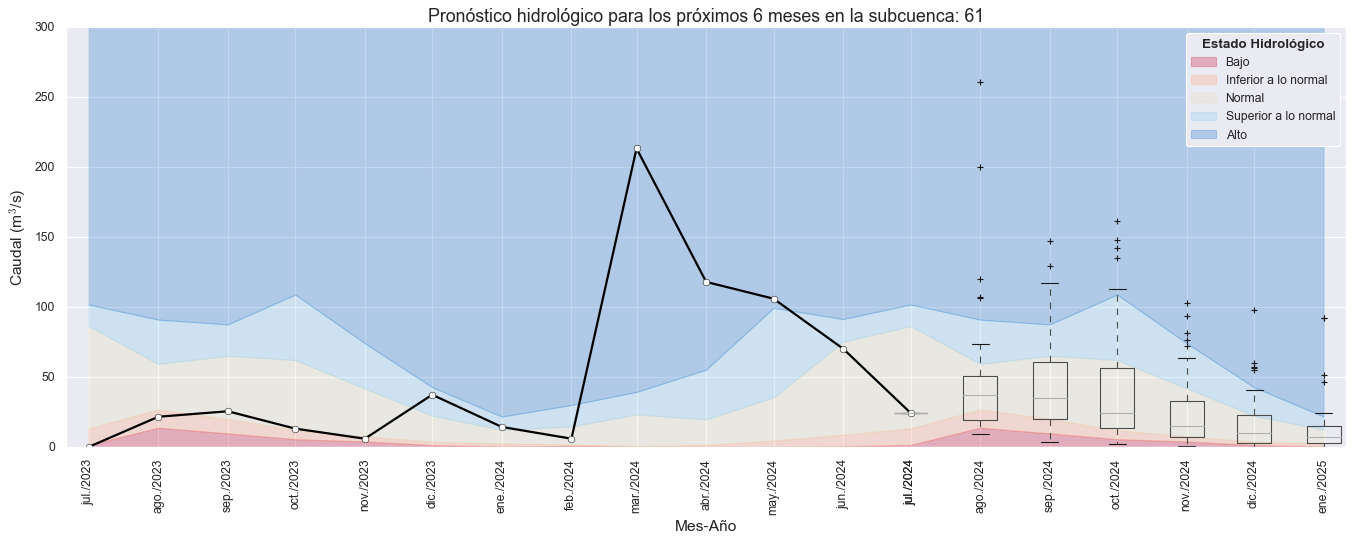

In [109]:
## Get the earliest date in BOTH plots combined
begin=pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).min()

## Add columns linepos and boxpos to the dataframes to show offset from earliest date
discharge_plot['linepos']=(discharge_plot['date']-begin).dt.days
concat_df['boxpos']=(concat_df['date']-begin).dt.days
df_stats['linepos'] = (df_stats['date']-begin).dt.days

## Plot plots - note I am using boxpos and linepos, not dates for x-axis
ax=concat_df[['discharge', 'boxpos']].boxplot(by='boxpos', widths=15, positions=concat_df.boxpos.unique(),figsize=(20,7))
ax.plot(discharge_plot['linepos'], discharge_plot['discharge'], label='_nolegend_',color = 'black',linewidth=2,marker='o', mfc='white', mec='k')
ax.fill_between(df_stats['linepos'], 0, df_stats['10th_percentile'], color='#CD233F', alpha=0.3,label="Bajo")
ax.fill_between(df_stats['linepos'], df_stats['10th_percentile'], df_stats['25th_percentile'], color='#FFA885', alpha=0.3,label="Inferior a lo normal")
ax.fill_between(df_stats['linepos'], df_stats['25th_percentile'], df_stats['75th_percentile'], color='#E7E2BC', alpha=0.3,label="Normal")
ax.fill_between(df_stats['linepos'], df_stats['75th_percentile'], df_stats['90th_percentile'], color='#8ECEEE', alpha=0.3,label="Superior a lo normal")
ax.fill_between(df_stats['linepos'], df_stats['90th_percentile'], discharge_max_plot,color='#2C7DCD', alpha=0.3,label="Alto")

## Set x-lim to include both line and boxes
ax.set_xlim([ min(concat_df.boxpos.min(), discharge_plot.linepos.min())-10, max(concat_df.boxpos.max(), discharge_plot.linepos.max()) + 10 ] )

## To change the x-axis ticks, get the list of all x-entries and sort
locs=(list(concat_df.boxpos.unique())+list(discharge_plot.linepos.unique()))
locs.sort()
ax.set_xticks(locs)
ax.set_ylim(0,discharge_max_plot)
# ax.set_ylim(0,500)

## To add labels get unique dates, sort them, convert to format you like and plot
ax.set_xticklabels(pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90 )

## Set x and y labels
ax.set_xlabel('Mes-Año',fontsize=14);
ax.set_title(f'Pronóstico hidrológico para los próximos 6 meses en la subcuenca: {codcuenca_n2}',fontsize=16)
ax.set_ylabel('Caudal (m$^3$/s)',fontsize=14);
ax.legend(loc='best',title='Estado Hidrológico',fancybox=True, title_fontproperties={'weight':'bold'})

plt.suptitle('');

In [110]:
# stats_fcst = concat_df.groupby('month')['discharge'].agg([np.min, q10, q25, q2, q75, q90,np.max, np.std,np.mean])
stats_fcst = concat_df.groupby('date')['discharge'].agg([np.min, q10, q25, q2, q75, q90,np.max, np.std,np.mean])
d = pd.DataFrame(index=pd.date_range(start=concat_df['date'].iloc[-7], end=concat_df['date'].iloc[-1], freq='MS',inclusive='both'))
stats_fcst['date'] = d.index
display(stats_fcst)

,amin,q10,q25,q2,q75,q90,amax,std,mean,date
date,,,,,,,,,,
2024-07-01,24.530924,24.530924,24.530924,24.530924,24.530924,24.530924,24.530924,0.000000,24.530924,2024-07-01
2024-08-01,9.118448,10.605803,19.707484,36.967499,51.068468,96.636718,261.048794,48.792957,47.934284,2024-08-01
2024-09-01,3.501600,8.661921,20.340136,35.419535,61.031192,100.816380,147.316254,35.246441,45.974451,2024-09-01
2024-10-01,2.403734,7.005637,14.015685,24.687644,56.608414,111.519821,161.622207,43.124734,43.866565,2024-10-01
2024-11-01,0.926667,3.465118,7.210545,15.227491,33.031660,69.888966,103.091402,26.802023,26.237441,2024-11-01
2024-12-01,0.333222,1.478403,3.275303,10.072448,23.172790,50.718467,98.307292,20.699633,17.309580,2024-12-01
2025-01-01,0.123818,0.552033,2.994428,6.963151,15.122928,24.320586,92.015756,20.464575,13.652386,2025-01-01


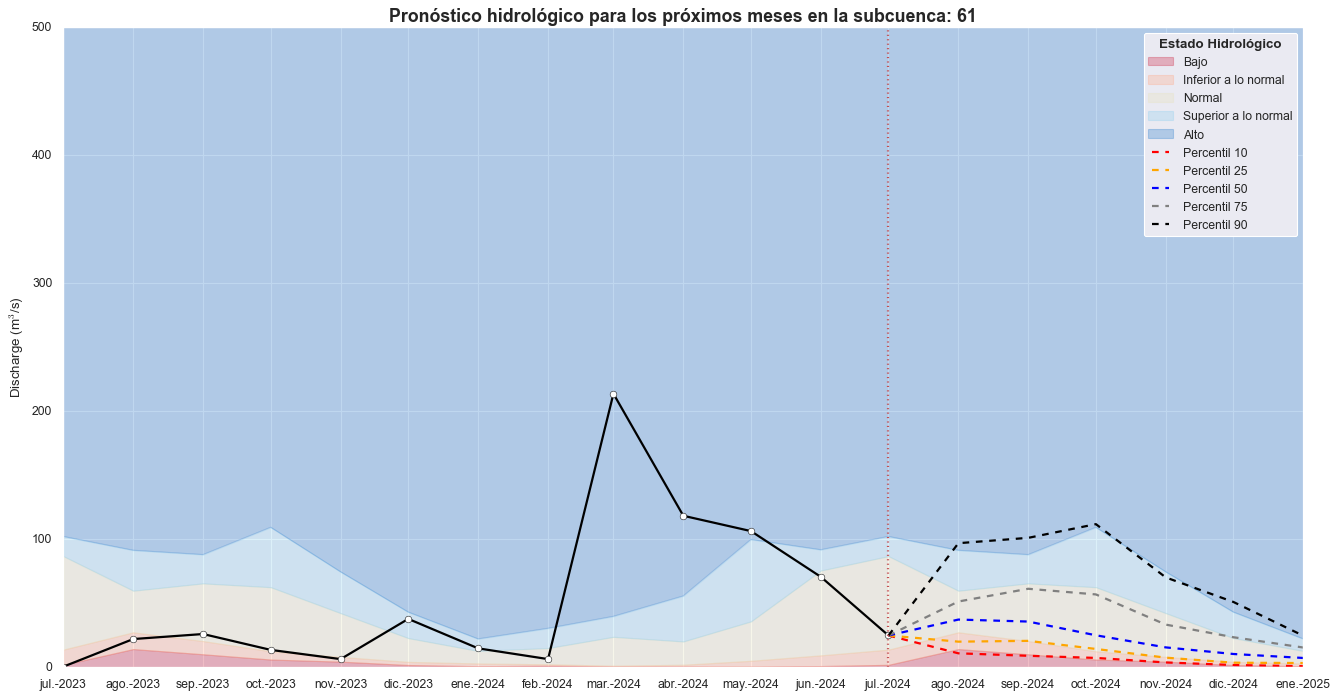

In [111]:
fig4, ax4 = plt.subplots(figsize=(20, 10))
ax4.plot(discharge_plot['date'],discharge_plot['discharge'],color = 'black',linewidth=2,marker='o', mfc='white', mec='k', label='_nolegend_');



# ax2.set_xticklabels(pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90 )
ax4.fill_between(df_stats['date'], 0, df_stats['10th_percentile'], color='#CD233F', alpha=0.3,label="Bajo")
ax4.fill_between(df_stats['date'], df_stats['10th_percentile'], df_stats['25th_percentile'], color='#FFA885', alpha=0.3,label="Inferior a lo normal")
ax4.fill_between(df_stats['date'], df_stats['25th_percentile'], df_stats['75th_percentile'], color='#E7E2BC', alpha=0.3,label="Normal")
ax4.fill_between(df_stats['date'], df_stats['75th_percentile'], df_stats['90th_percentile'], color='#8ECEEE', alpha=0.3,label="Superior a lo normal")
ax4.fill_between(df_stats['date'], df_stats['90th_percentile'], 600,color='#2C7DCD', alpha=0.3,label="Alto")

ax4.plot(stats_fcst['date'],stats_fcst['q10'],color = 'red',linestyle = '--',linewidth=2, mec='k', label='Percentil 10')
ax4.plot(stats_fcst['date'],stats_fcst['q25'],color = 'orange',linestyle = '--',linewidth=2, mec='k', label='Percentil 25')
ax4.plot(stats_fcst['date'],stats_fcst['q2'],color = 'blue',linestyle = '--',linewidth=2, mec='k', label='Percentil 50')
ax4.plot(stats_fcst['date'],stats_fcst['q75'],color = 'gray',linestyle = '--',linewidth=2, mec='k', label='Percentil 75')
ax4.plot(stats_fcst['date'],stats_fcst['q90'],color = 'black',linestyle = '--',linewidth=2, mec='k', label='Percentil 90')

ax4.set_title(f'Pronóstico hidrológico para los próximos meses en la subcuenca: {codcuenca_n2}',fontweight='bold',fontsize=16)
# ax4.set_ylim(0,discharge_max_plot)
ax4.set_ylim(0,500)
ax4.legend(loc='best',title='Estado Hidrológico',fancybox=True, title_fontproperties={'weight':'bold'})
ax4.set_ylabel('Discharge (m$^3$/s)');

ax4.axvline(x = stats_fcst['date'].iloc[0], color = 'r',label = 'now', linestyle=':', linewidth=2, mfc='white', mec='k');

ax4.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);

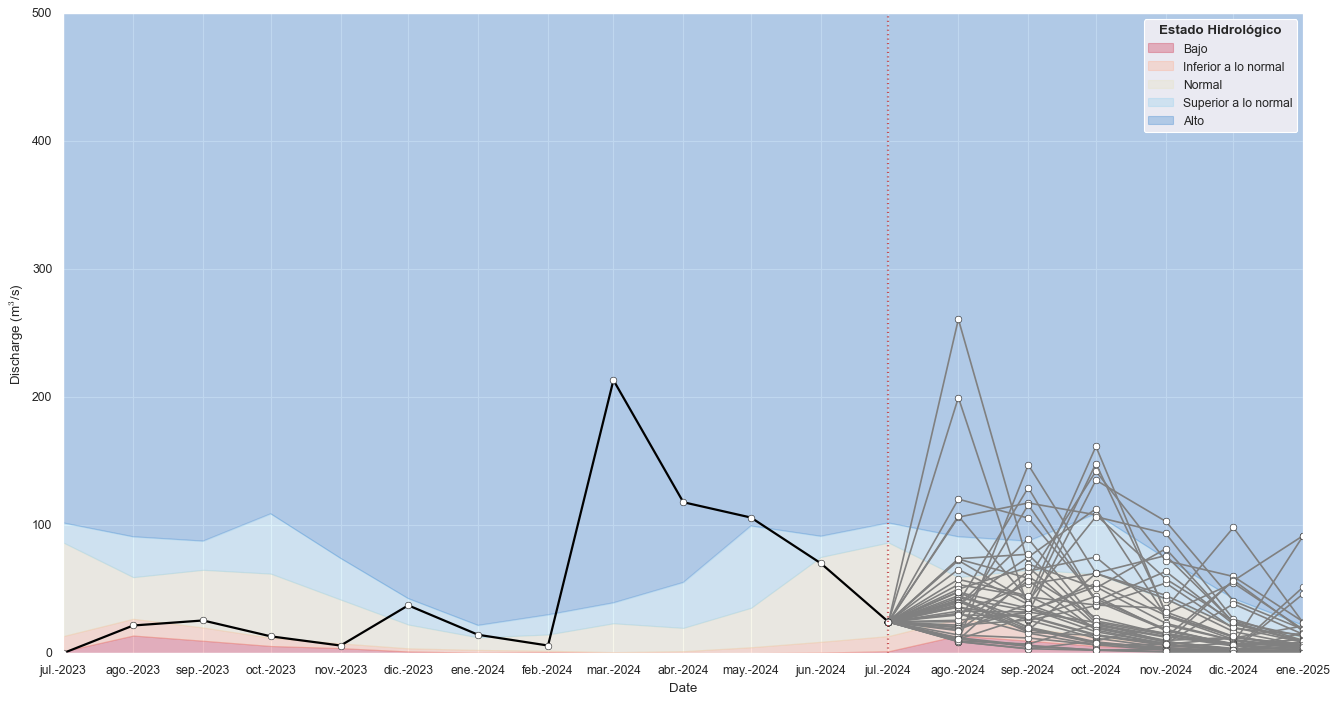

In [112]:
fig2, ax2 = plt.subplots(figsize=(20, 10))
ax2.plot(discharge_plot['date'],discharge_plot['discharge'],color = 'black',linewidth=2,marker='o', mfc='white', mec='k', label='_nolegend_');
for group,data in concat_df.groupby('group'):
    ax2.plot(data['date'],data['discharge'],color = 'gray',linewidth=1.5,marker='o', mfc='white', mec='k', label='_nolegend_')
ax2.set_xlabel('Date');
## To add labels get unique dates, sort them, convert to format you like and plot
# ax2.set_xticklabels(pd.concat([discharge_plot.date, pd.Series(concat_df.date.unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90 )
ax2.fill_between(df_stats['date'], 0, df_stats['10th_percentile'], color='#CD233F', alpha=0.3,label="Bajo")
ax2.fill_between(df_stats['date'], df_stats['10th_percentile'], df_stats['25th_percentile'], color='#FFA885', alpha=0.3,label="Inferior a lo normal")
ax2.fill_between(df_stats['date'], df_stats['25th_percentile'], df_stats['75th_percentile'], color='#E7E2BC', alpha=0.3,label="Normal")
ax2.fill_between(df_stats['date'], df_stats['75th_percentile'], df_stats['90th_percentile'], color='#8ECEEE', alpha=0.3,label="Superior a lo normal")
ax2.fill_between(df_stats['date'], df_stats['90th_percentile'], 600,color='#2C7DCD', alpha=0.3,label="Alto")
# ax2.set_ylim(0,discharge_max_plot)
ax2.set_ylim(0,500)
ax2.legend(loc='best',title='Estado Hidrológico',fancybox=True, title_fontproperties={'weight':'bold'})
ax2.set_ylabel('Discharge (m$^3$/s)');

ax2.axvline(x = stats_fcst['date'].iloc[0], color = 'r',label = 'now', linestyle=':', linewidth=2, mfc='white', mec='k');

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 1 month
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))   #optional formatting 
plt.xticks(rotation=0);

### Graficar ESP condicional

A continuación seleccionaremos algunos años similares

In [148]:
selected_years = [1990, 2009, 2014, 2017, 2018]
concat_df['year_analogue'] = concat_df['year_analogue'].astype(int)
years_to_select = [int(year) for year in selected_years]

# Crear el subset
filtered_concat_df = concat_df[concat_df['year_analogue'].isin(years_to_select)]

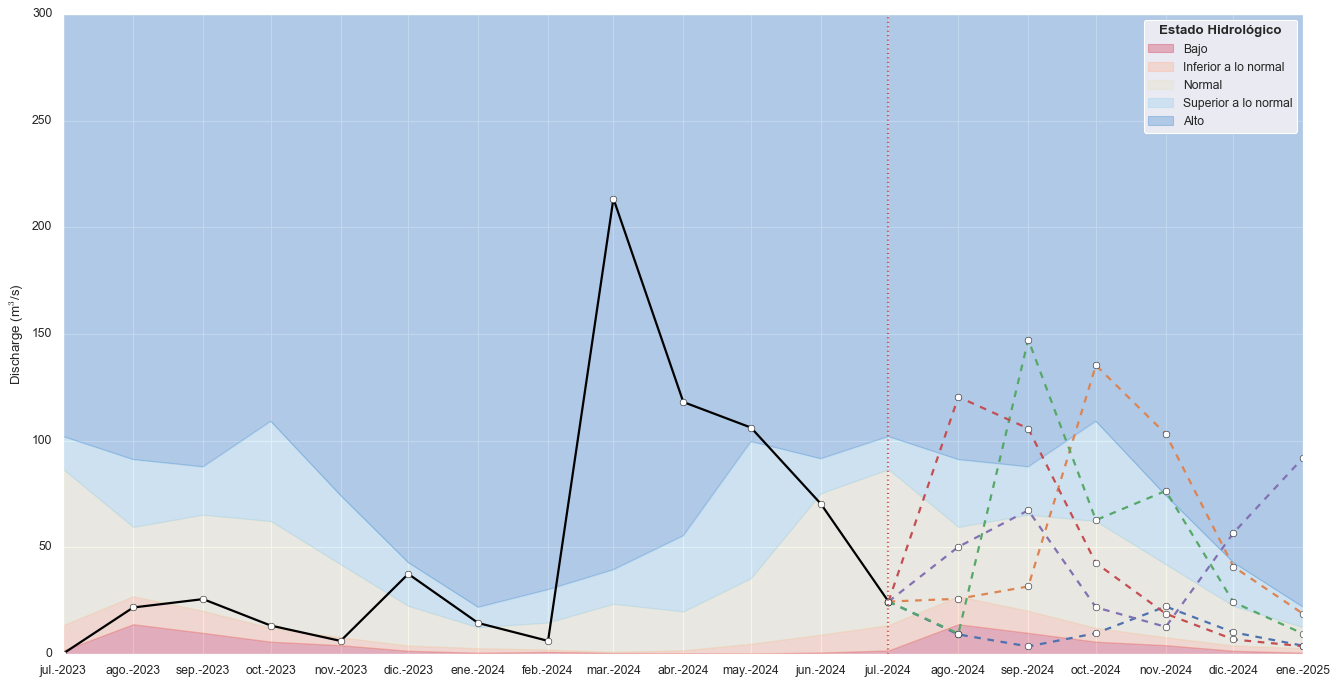

In [152]:
fig5, ax5 = plt.subplots(figsize=(20, 10))

# Gráfico de la serie principal
ax5.plot(discharge_plot['date'], discharge_plot['discharge'], color='black', linewidth=2, marker='o', mfc='white', mec='k', label='_nolegend_')

# Gráfico de los grupos filtrados
for group, data in filtered_concat_df.groupby('group'):
    ax5.plot(data['date'], data['discharge'], linestyle = '--', linewidth=2, marker='o', mfc='white', mec='k', label='_nolegend_')

# Etiquetas en el eje X
# ax5.set_xticklabels(pd.concat([discharge_plot['date'], pd.Series(filtered_concat_df['date'].unique())]).sort_values().reset_index(drop=True).dt.strftime('%b/%Y'), rotation=90)

# Colores para los percentiles
ax5.fill_between(df_stats['date'], 0, df_stats['10th_percentile'], color='#CD233F', alpha=0.3, label="Bajo")
ax5.fill_between(df_stats['date'], df_stats['10th_percentile'], df_stats['25th_percentile'], color='#FFA885', alpha=0.3, label="Inferior a lo normal")
ax5.fill_between(df_stats['date'], df_stats['25th_percentile'], df_stats['75th_percentile'], color='#E7E2BC', alpha=0.3, label="Normal")
ax5.fill_between(df_stats['date'], df_stats['75th_percentile'], df_stats['90th_percentile'], color='#8ECEEE', alpha=0.3, label="Superior a lo normal")
ax5.fill_between(df_stats['date'], df_stats['90th_percentile'], 600, color='#2C7DCD', alpha=0.3, label="Alto")

# Límites del eje Y y leyenda
ax5.set_ylim(0, 300)
ax5.legend(loc='best', title='Estado Hidrológico', fancybox=True, title_fontproperties={'weight': 'bold'})
ax5.set_ylabel('Discharge (m$^3$/s)')

# Línea vertical para indicar la fecha actual o t0
ax5.axvline(x=stats_fcst['date'].iloc[0], color='r', label='now', linestyle=':', linewidth=2, mfc='white', mec='k')

# Configuración del eje X
ax5.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo de 1 mes
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))  # Formato de fecha

plt.xticks(rotation=0)
plt.show()


In [153]:
concat_df['percentile_range'] = ''
concat_df['percentile_range_summary'] = ''
values_months = ['Low Flow','Below Normal','Normal Range','Above Normal','High Flow']
values_months_summary = ['Low','Normal','High']

for i in range(len(concat_df)):
    # Extract the current month 
    m = concat_df.month[i]
    y = concat_df.year[i]
    # pmin = min_values.query('month==@m')['discharge'].item()
    pmin = 0
    p90 = percentiles.query('percentile == 0.90 & month==@m')['discharge_percentile'].item()
    p75 = percentiles.query('percentile == 0.75 & month==@m')['discharge_percentile'].item()
    p25 = percentiles.query('percentile == 0.25 & month==@m')['discharge_percentile'].item()
    p10 = percentiles.query('percentile == 0.10 & month==@m')['discharge_percentile'].item()
    pmax = max_values.query('month==@m')['discharge'].item()
    value = concat_df.discharge[i]
    category = pd.cut([value],bins=[pmin,p10,p25,p75,p90,pmax],labels=values_months)
    category_summary = pd.cut([value],bins=[pmin,p25,p75,pmax],labels=values_months_summary)
    concat_df.loc[concat_df.eval('index==@i'),'percentile_range'] = category[0]
    concat_df.loc[concat_df.eval('index==@i'),'percentile_range_summary'] = category_summary[0]

In [134]:
# OJO: SELECT FORECAST LEADTIME 
forecast_leadtime = 3
# month_outlook = discharge_plot['date'] + pd.DateOffset(months=+forecast_leadtime)
month_outlook = discharge_plot['month'].iloc[-1] + forecast_leadtime

In [135]:
if month_outlook > 12:
    month_outlook = month_outlook - 12

month_outlook

10

In [136]:
category_counts = concat_df.query('month==@month_outlook')['percentile_range'].value_counts()
category_counts = category_counts.to_frame()
category_counts = category_counts.sort_index(key=lambda x: x.map({val:idx for idx,val in enumerate(values_months)}))

In [137]:
display(category_counts)

,percentile_range
Low Flow,3
Below Normal,7
Normal Range,23
Above Normal,6
High Flow,3


In [138]:
category_counts_summary = concat_df.query('month==@month_outlook')['percentile_range_summary'].value_counts()
category_counts_summary = category_counts_summary.to_frame()
category_counts_summary = category_counts_summary.sort_index(key=lambda x: x.map({val:idx for idx,val in enumerate(values_months_summary)}))

In [139]:
display(category_counts_summary)

,percentile_range_summary
Low,10
Normal,23
High,9


In [140]:
category_counts['percentage_ensemble'] = round((category_counts['percentile_range']/category_counts['percentile_range'].sum())*100,1)
category_counts_summary['percentage_ensemble'] = round((category_counts_summary['percentile_range_summary']/category_counts_summary['percentile_range_summary'].sum())*100,1)

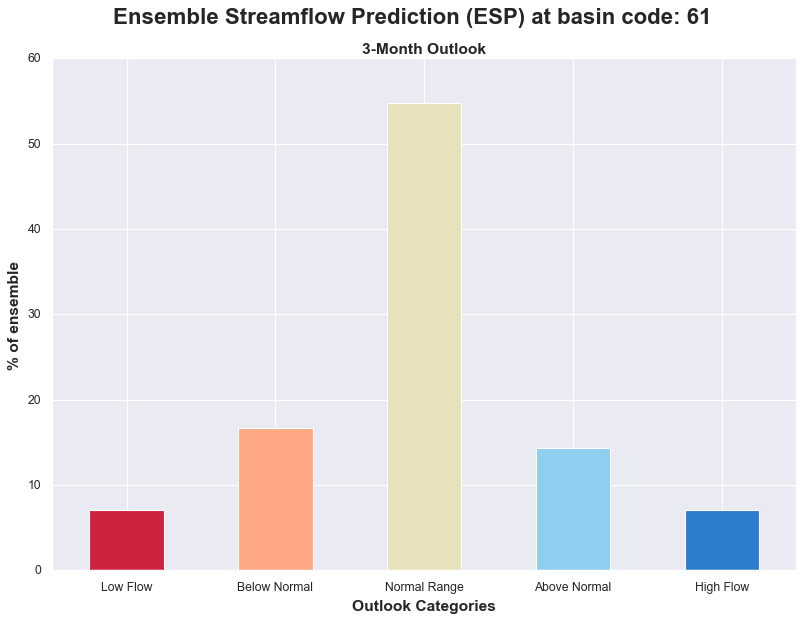

In [141]:
import matplotlib.colors as mcolors
color_mapping = {
    'Low Flow':'#CD233F',
    'Below Normal': '#FFA885',
    'Normal Range': '#E7E2BC',
    'Above Normal': '#8ECEEE',
    'High Flow': '#2C7DCD'
}

column_name = category_counts.index.to_list()
colors = [mcolors.to_rgb(color_mapping.get(x,'#808080')) for x in category_counts.index]
ax3 = category_counts['percentage_ensemble'].plot(kind='bar',color=colors,figsize=(12, 8));
plt.xticks(range(len(category_counts.index)),column_name,rotation=0,horizontalalignment='center');
plt.xlabel('Outlook Categories',fontweight='bold',fontsize=14);
plt.ylabel('% of ensemble',fontweight='bold',fontsize=14);
plt.suptitle(f'Ensemble Streamflow Prediction (ESP) at basin code: {codcuenca_n2}',fontweight='bold',fontsize=20);
plt.title(f"{forecast_leadtime}-Month Outlook",fontweight='bold',fontsize=14);

In [142]:
display(category_counts)

,percentile_range,percentage_ensemble
Low Flow,3,7.1
Below Normal,7,16.7
Normal Range,23,54.8
Above Normal,6,14.3
High Flow,3,7.1


In [143]:
display(category_counts_summary)

,percentile_range_summary,percentage_ensemble
Low,10,23.8
Normal,23,54.8
High,9,21.4


In [144]:
column_name_sum_espanol = ['Bajo','Normal','Alto']
# column_name_sum_espanol = ['Normal','Alto']

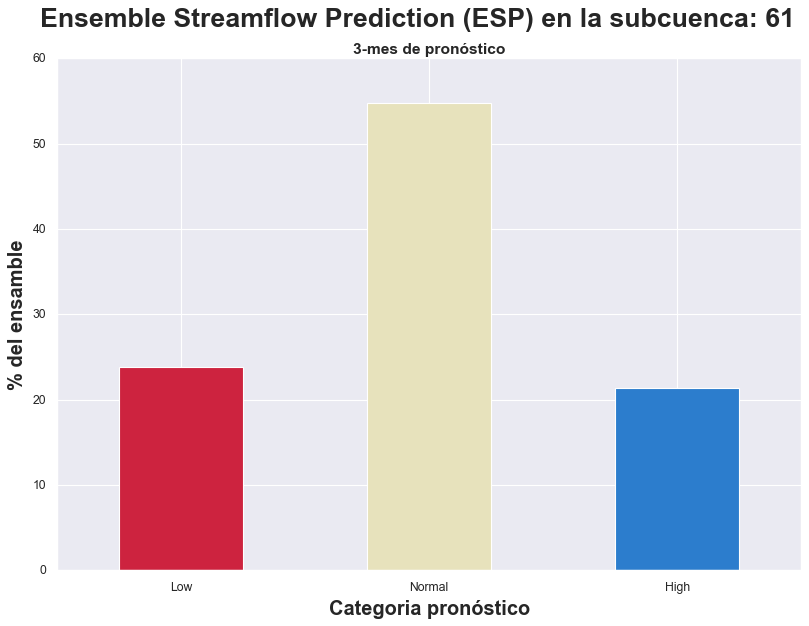

In [145]:
font_size = 18
color_mapping_summary = {
    'Low':'#CD233F',
    'Normal': '#E7E2BC',
    'High': '#2C7DCD'
}

column_name_sum = category_counts_summary.index.to_list()
colors_sum = [mcolors.to_rgb(color_mapping_summary.get(y,'#808080')) for y in category_counts_summary.index]
ax4 = category_counts_summary['percentage_ensemble'].plot(kind='bar',color=colors_sum,figsize=(12, 8));
plt.xticks(range(len(category_counts_summary.index)),column_name_sum_espanol,rotation=0,horizontalalignment='center');
plt.xticks(range(len(category_counts_summary.index)),column_name_sum,rotation=0,horizontalalignment='center');
plt.xlabel('Categoria pronóstico',fontweight='bold',fontsize=font_size);
plt.ylabel('% del ensamble',fontweight='bold',fontsize=font_size);
plt.suptitle(f'Ensemble Streamflow Prediction (ESP) en la subcuenca: {codcuenca_n2}',fontweight='bold',fontsize=font_size+6);
plt.title(f"{forecast_leadtime}-mes de pronóstico",fontweight='bold',fontsize=14);
